In [98]:
import pandas as pd
from tqdm import tqdm
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pandarallel.initialize(progress_bar=True, use_memory_fs=True)

DATA_ROOT = '../data'

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# Read in the data
df_db = pd.read_csv(f'{DATA_ROOT}/raw/DS_train/DS_train(2020-06--2022-06-01).csv', engine="pyarrow", delimiter='\t')
df_db.shape

(69173886, 4)

In [4]:
df_db.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69173886 entries, 0 to 69173885
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   WebPriceId    int64         
 1   DateObserve   datetime64[ns]
 2   StockStatus   object        
 3   CurrentPrice  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.1+ GB


In [5]:
DATE_COLUMN = "DateObserve"
PRICE_COLUMN = "CurrentPrice"
ID_COLUMN = "WebPriceId"
STOCK_STATUS_COLUMN = "StockStatus"

In [9]:
# df_db = df_db[:10000000].groupby(ID_COLUMN).filter(lambda x: len(x) > 10)
# df_db.to_csv(f'{DATA_ROOT}/interim/data_filtered_count_more_than_ten.csv', index=False)
df_db = pd.read_csv(f'{DATA_ROOT}/interim/data_filtered_count_more_than_ten.csv', engine="pyarrow", delimiter=',')

In [11]:
# Filter out the data that is not available
df_db = df_db[df_db[STOCK_STATUS_COLUMN] == "InStock"]

In [12]:
df_db.groupby(ID_COLUMN).count()[DATE_COLUMN].value_counts()

11     12685
12     11121
13      9675
14      8815
15      8081
       ...  
139        1
155        1
160        1
169        1
153        1
Name: DateObserve, Length: 153, dtype: int64

In [13]:
df_db_sample = df_db.head(10000000)

In [14]:
df_db_sample

,WebPriceId,DateObserve,StockStatus,CurrentPrice
0,1,2020-06-25 19:23:21.010,InStock,49.0
2,1,2020-09-08 15:39:01.663,InStock,49.0
4,1,2020-09-09 07:38:41.163,InStock,49.0
6,1,2020-11-20 16:47:57.243,InStock,49.0
8,1,2020-12-20 23:55:45.830,InStock,49.0
...,...,...,...,...
4287877,2863188,2021-01-13 07:43:21.607,InStock,401.0
4287878,2863188,2021-01-18 13:35:35.483,InStock,446.0
4287879,2863188,2021-01-21 01:00:12.000,InStock,341.0
4287880,2863188,2021-01-27 15:09:51.450,InStock,401.0


In [251]:
# df_db_sample.groupby(ID_COLUMN)

# For each time series for each product, we want to calculate standard deviation of the price, and the mean of the price, trend of the price
# We will use these features for clustering


def get_price_std(df):
    return df[PRICE_COLUMN].std()

def get_time_series_of_web_price_id(df, web_price_id):
    return df[df[ID_COLUMN] == web_price_id]

def get_price_mean(df):
    return df[PRICE_COLUMN].mean()

def get_price_trend(df):
    return df[PRICE_COLUMN].diff().mean()

def get_price_trend_std(df):
    return df[PRICE_COLUMN].diff().std()

def get_price_trend_max(df):
    return df[PRICE_COLUMN].diff().max()

def get_price_trend_min(df):
    return df[PRICE_COLUMN].diff().min()

def get_price_trend_skew(df):
    return df[PRICE_COLUMN].diff().skew()

def get_price_trend_kurtosis(df):
    return df[PRICE_COLUMN].diff().kurtosis()

def get_price_trend_quantile_25(df):
    return df[PRICE_COLUMN].diff().quantile(0.25)

def get_price_trend_quantile_75(df):
    return df[PRICE_COLUMN].diff().quantile(0.75)

def get_price_max(df):
    return df[PRICE_COLUMN].max()

def get_price_min(df):
    return df[PRICE_COLUMN].min()

def get_price_range(df):
    return df[PRICE_COLUMN].max() - df[PRICE_COLUMN].min()




# Apply the functions to the data using pandas parallel_apply
features = {
    "price_std": get_price_std,
    "price_max": get_price_max,
    "price_min": get_price_min,
    "price_mean": get_price_mean,
    # "price_range": get_price_range,
    # "price_trend": get_price_trend,
    "price_trend_std": get_price_trend_std,
    "price_trend_max": get_price_trend_max,
    "price_trend_min": get_price_trend_min,
    "price_trend_skew": get_price_trend_skew,
    "price_trend_kurtosis": get_price_trend_kurtosis,
    # "price_trend_quantile_25": get_price_trend_quantile_25,
    # "price_trend_quantile_75": get_price_trend_quantile_75,

}

def add_features(df, features):
    # print(df)
    # webprice_dict = {ID_COLUMN: df[ID_COLUMN].iloc[0]}
    features_dict = {k: v(df) for k, v in features.items()}
    new_df = pd.Series({**features_dict})
    return new_df

def add_time_series_features(df, features) -> pd.DataFrame:
    df = df.groupby(ID_COLUMN).parallel_apply(add_features, features=features)
    return df

ids_features = add_time_series_features(df_db_sample[:10000000], features)


print("="*80)
ids_features


,price_std,price_max,price_min,price_mean,price_trend_std,price_trend_max,price_trend_min,price_trend_skew,price_trend_kurtosis
WebPriceId,,,,,,,,,
1,0.000000,49.0,49.0,49.000000,0.000000,0.0,0.0,0.000000,0.000000
2,3.872983,59.0,47.0,50.500000,0.969195,3.0,-1.0,0.734768,0.812780
3,614.742780,4511.5,2161.0,2727.038462,687.895147,596.0,-2007.5,-2.049857,4.348725
4,8.924366,73.5,15.5,44.329787,8.556180,27.5,-27.5,-0.190289,3.816375
5,2.886751,65.0,55.0,55.833333,3.015113,10.0,0.0,3.316625,11.000000
...,...,...,...,...,...,...,...,...,...
11407716,49.685191,676.0,512.0,594.272727,70.530450,80.0,-137.0,-0.704992,0.063611
11427663,32.267631,818.0,719.0,779.000000,19.170579,21.0,-46.0,-0.471163,1.035227
11427890,615.700931,12382.0,10694.0,11651.000000,919.666936,950.0,-950.0,0.373123,-2.157202


In [252]:
# Cluster the data using KMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
ids_features.reset_index(inplace=True)
scaled_features = scaler.fit_transform(ids_features)

n_clusters = 8

# Cluster the data
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(scaled_features)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the data
ids_features["cluster"] = cluster_labels

ids_features




,WebPriceId,price_std,price_max,price_min,price_mean,price_trend_std,price_trend_max,price_trend_min,price_trend_skew,price_trend_kurtosis,cluster
0,1,0.000000,49.0,49.0,49.000000,0.000000,0.0,0.0,0.000000,0.000000,6
1,2,3.872983,59.0,47.0,50.500000,0.969195,3.0,-1.0,0.734768,0.812780,6
2,3,614.742780,4511.5,2161.0,2727.038462,687.895147,596.0,-2007.5,-2.049857,4.348725,6
3,4,8.924366,73.5,15.5,44.329787,8.556180,27.5,-27.5,-0.190289,3.816375,6
4,5,2.886751,65.0,55.0,55.833333,3.015113,10.0,0.0,3.316625,11.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
155973,11407716,49.685191,676.0,512.0,594.272727,70.530450,80.0,-137.0,-0.704992,0.063611,7
155974,11427663,32.267631,818.0,719.0,779.000000,19.170579,21.0,-46.0,-0.471163,1.035227,7
155975,11427890,615.700931,12382.0,10694.0,11651.000000,919.666936,950.0,-950.0,0.373123,-2.157202,7
155976,11433578,264.026557,2268.0,1590.0,1989.250000,498.641555,678.0,-638.0,0.184352,-1.557478,7


In [253]:
# Check out the clusters and their sizes
cluster_ids = ids_features.groupby("cluster").groups

for cl in cluster_ids:
    print(f"Cluster {cl}: {len(cluster_ids[cl])} ids")

Cluster 0: 16537 ids
Cluster 1: 63 ids
Cluster 2: 1993 ids
Cluster 3: 81417 ids
Cluster 4: 4 ids
Cluster 5: 41 ids
Cluster 6: 51661 ids
Cluster 7: 4262 ids


In [254]:
# Use PCA to reduce the dimensionality of the data to 2D for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(scaled_features)
pca_features = pca.transform(scaled_features)



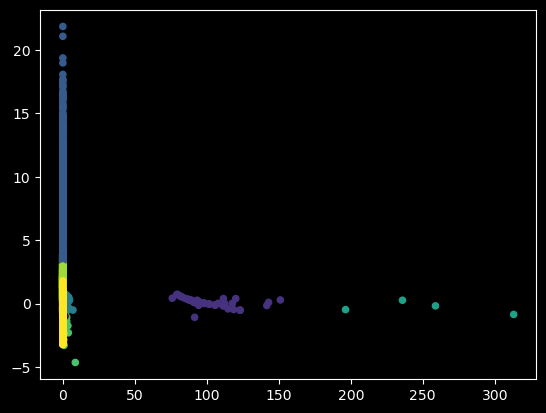

In [255]:
# Plot the data

# Set dark theme for plt
plt.style.use('dark_background')

plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.show()

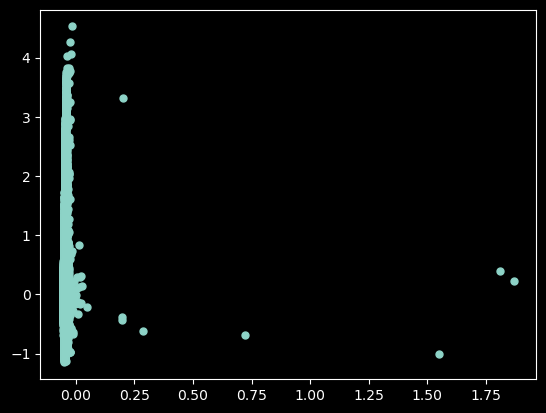

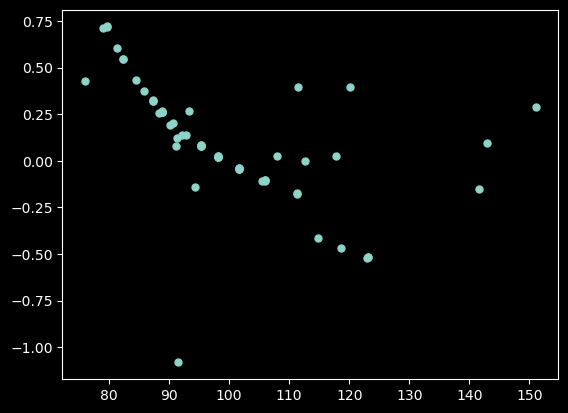

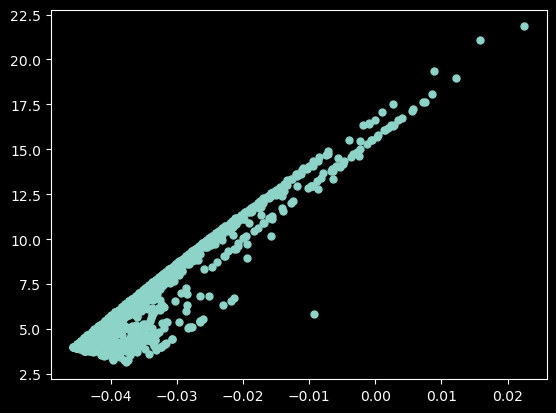

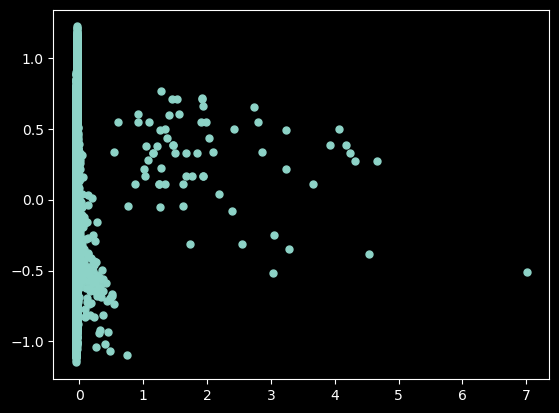

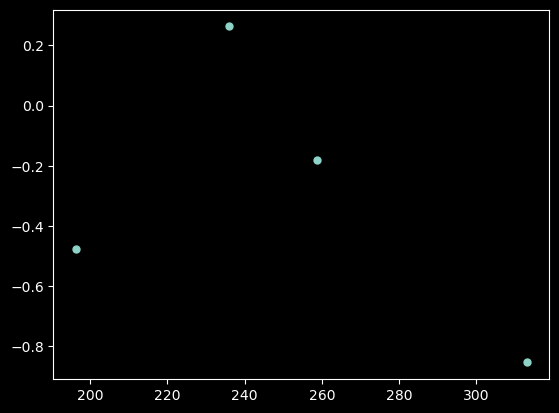

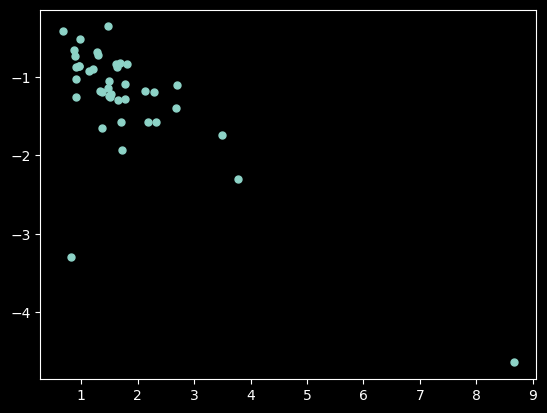

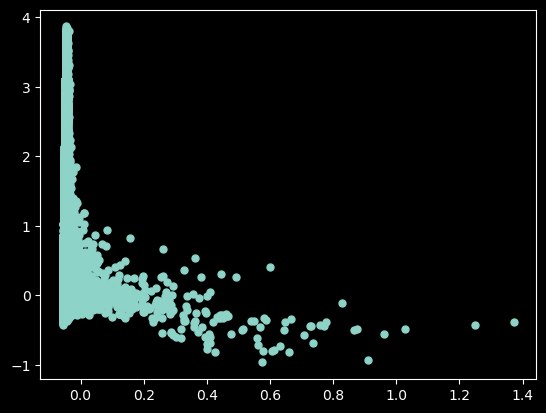

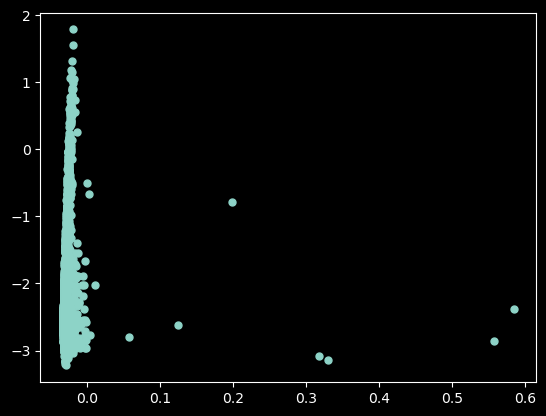

In [256]:
# Plot the clusters
for cluster in range(
    0, n_clusters
):
    plt.scatter(pca_features[cluster_labels == cluster, 0], pca_features[cluster_labels == cluster, 1], s=25, cmap='viridis')
    plt.show()


In [257]:
pca_features.shape

(155978, 2)

In [258]:
# Find mean plots for each cluster
cluster_mean_features = ids_features.groupby("cluster").mean()

cluster_mean_features


,WebPriceId,price_std,price_max,price_min,price_mean,price_trend_std,price_trend_max,price_trend_min,price_trend_skew,price_trend_kurtosis
cluster,,,,,,,,,,
0,1.623403e+06,2.951674e+03,1.721757e+04,5.836031e+03,8.071853e+03,3.140052e+03,1.050276e+04,-5.161013e+03,2.113631,8.684016
1,2.700589e+06,3.167289e+08,1.034653e+09,5.400635e+03,1.053124e+08,4.820614e+08,1.030648e+09,-1.011635e+09,0.050042,4.917300
2,1.170515e+05,1.518954e+03,1.081513e+04,6.118488e+02,1.059979e+03,1.479358e+03,1.705198e+03,-9.981820e+03,-5.140224,38.057545
3,2.438191e+06,6.358852e+03,2.756429e+04,3.936995e+03,6.937574e+03,9.363056e+03,2.259677e+04,-2.207112e+04,0.186470,0.653682
4,2.694080e+06,8.615184e+08,2.374027e+09,2.099000e+04,4.208775e+08,1.053660e+09,2.374002e+09,-2.099034e+09,0.243625,3.238883
5,1.097577e+06,1.549908e+06,1.197151e+07,6.190797e+06,8.333886e+06,2.160463e+06,5.058450e+06,-3.827761e+06,0.500551,0.735178
6,2.948707e+05,3.871352e+03,2.491627e+04,1.063935e+04,1.589045e+04,4.928485e+03,1.137551e+04,-9.972632e+03,-0.267568,2.816669
7,1.068881e+07,1.055947e+03,9.992920e+03,6.685786e+03,7.922517e+03,1.132681e+03,1.887646e+03,-2.047248e+03,-0.000024,1.270683


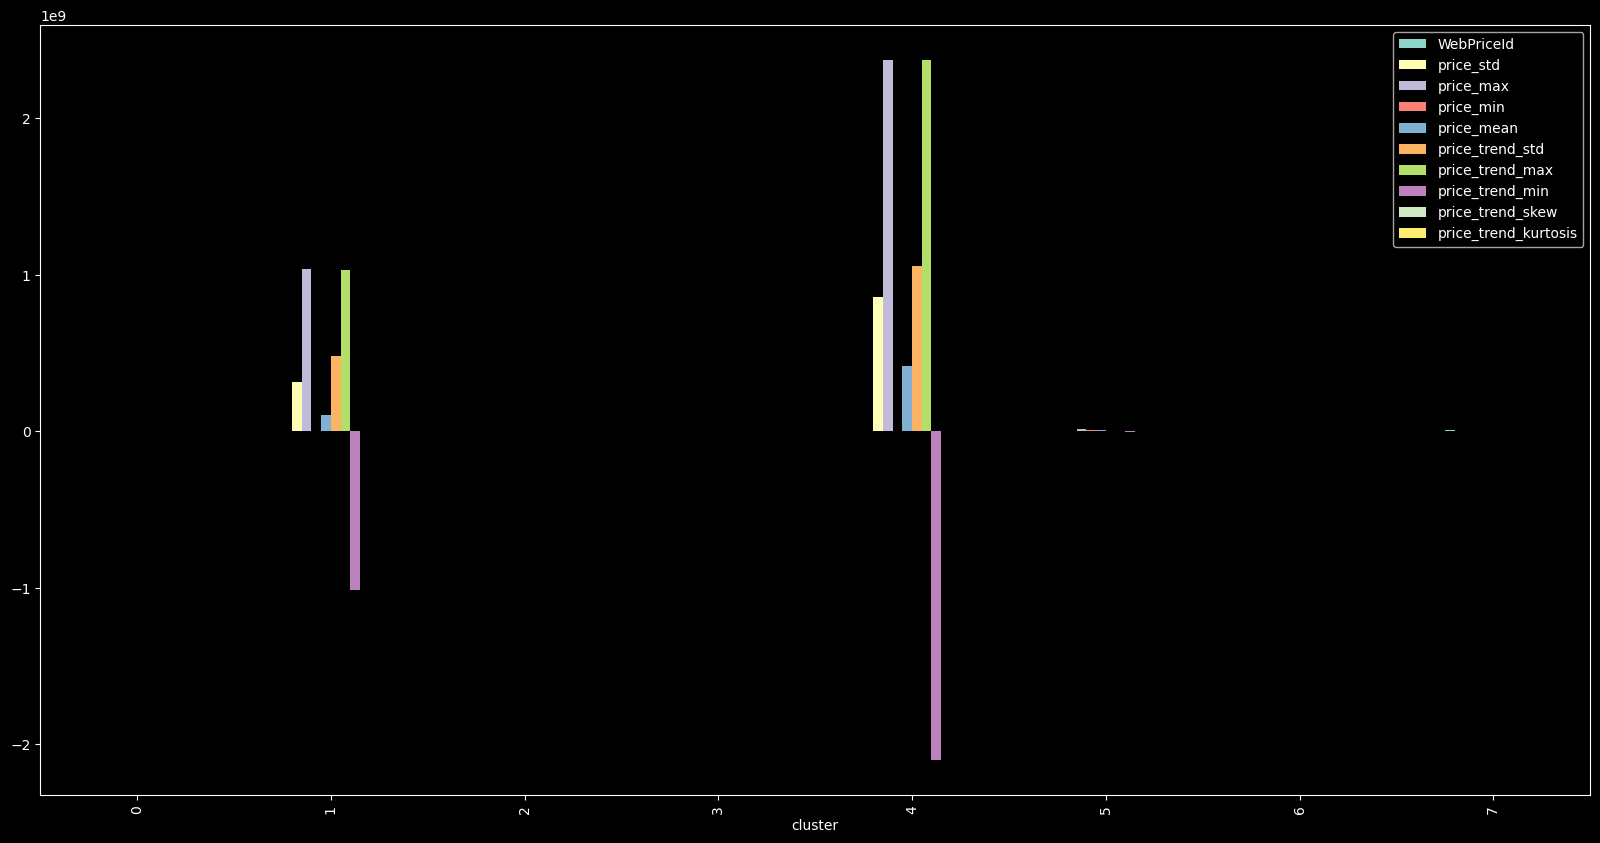

In [259]:

# Plot the mean features for each cluster
cluster_mean_features.plot(kind="bar", figsize=(20, 10))
plt.show()

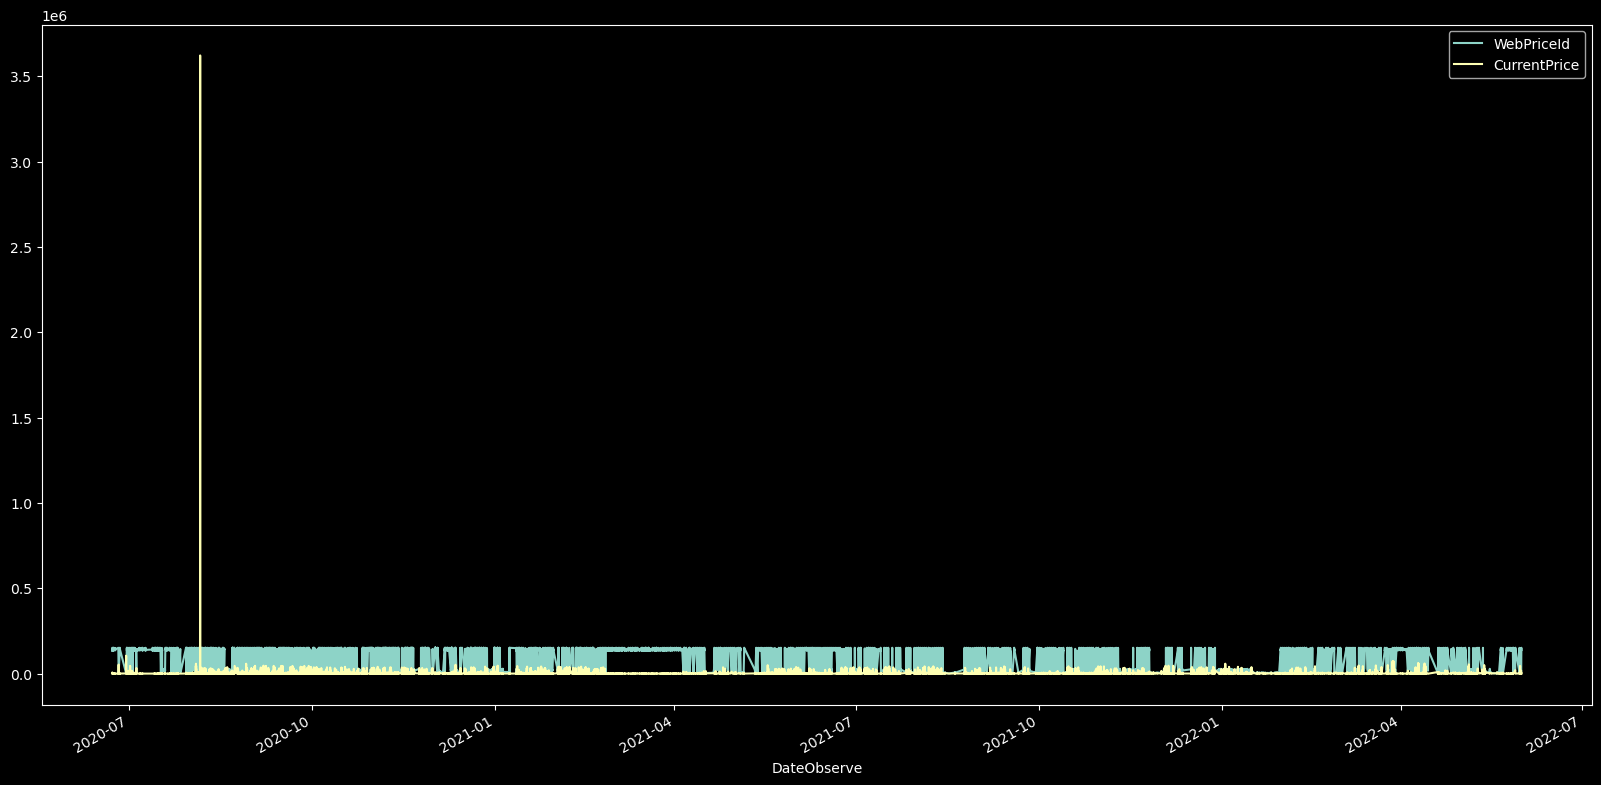

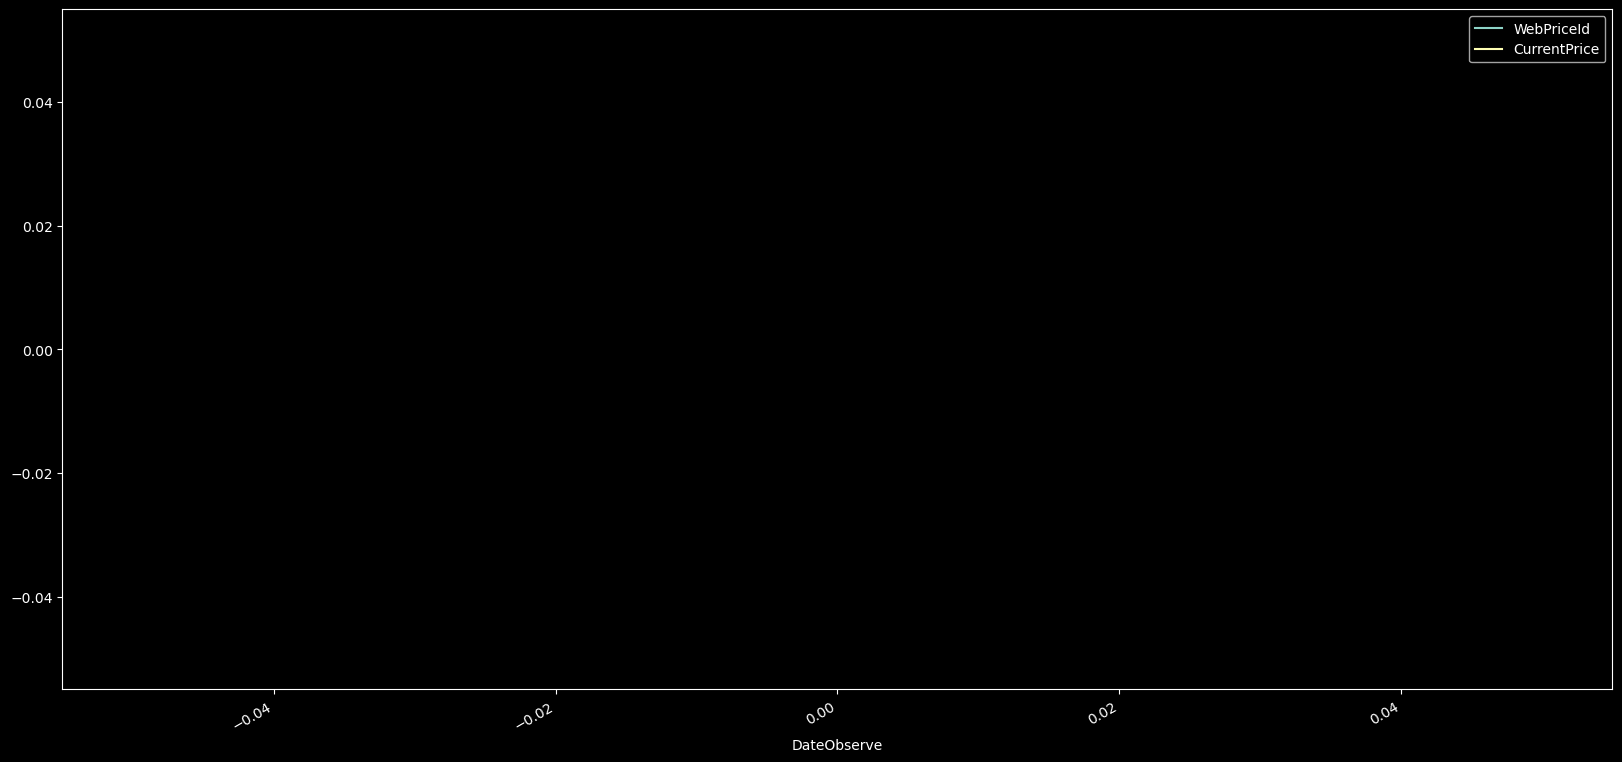

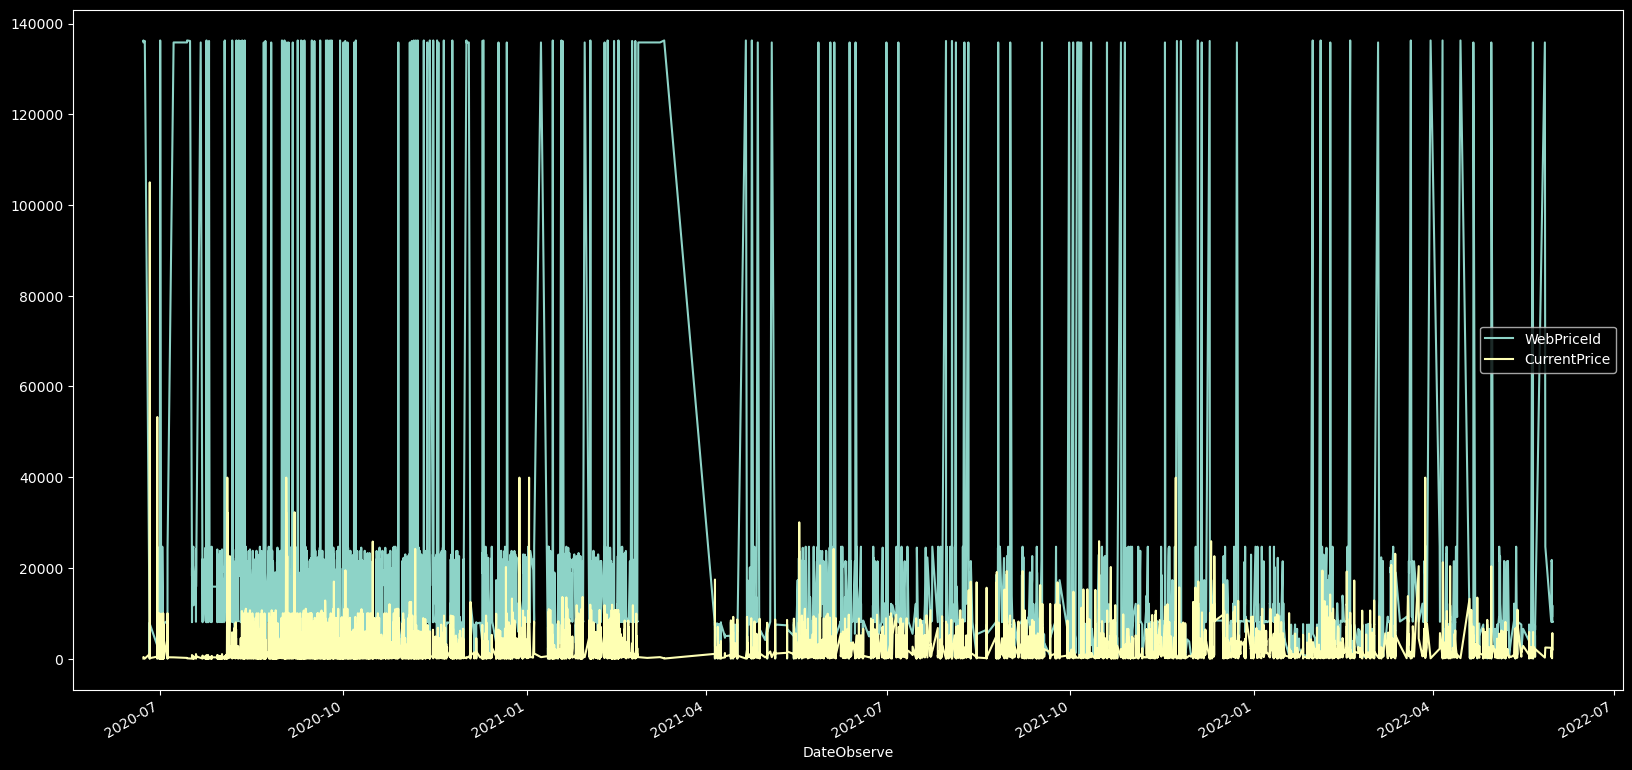

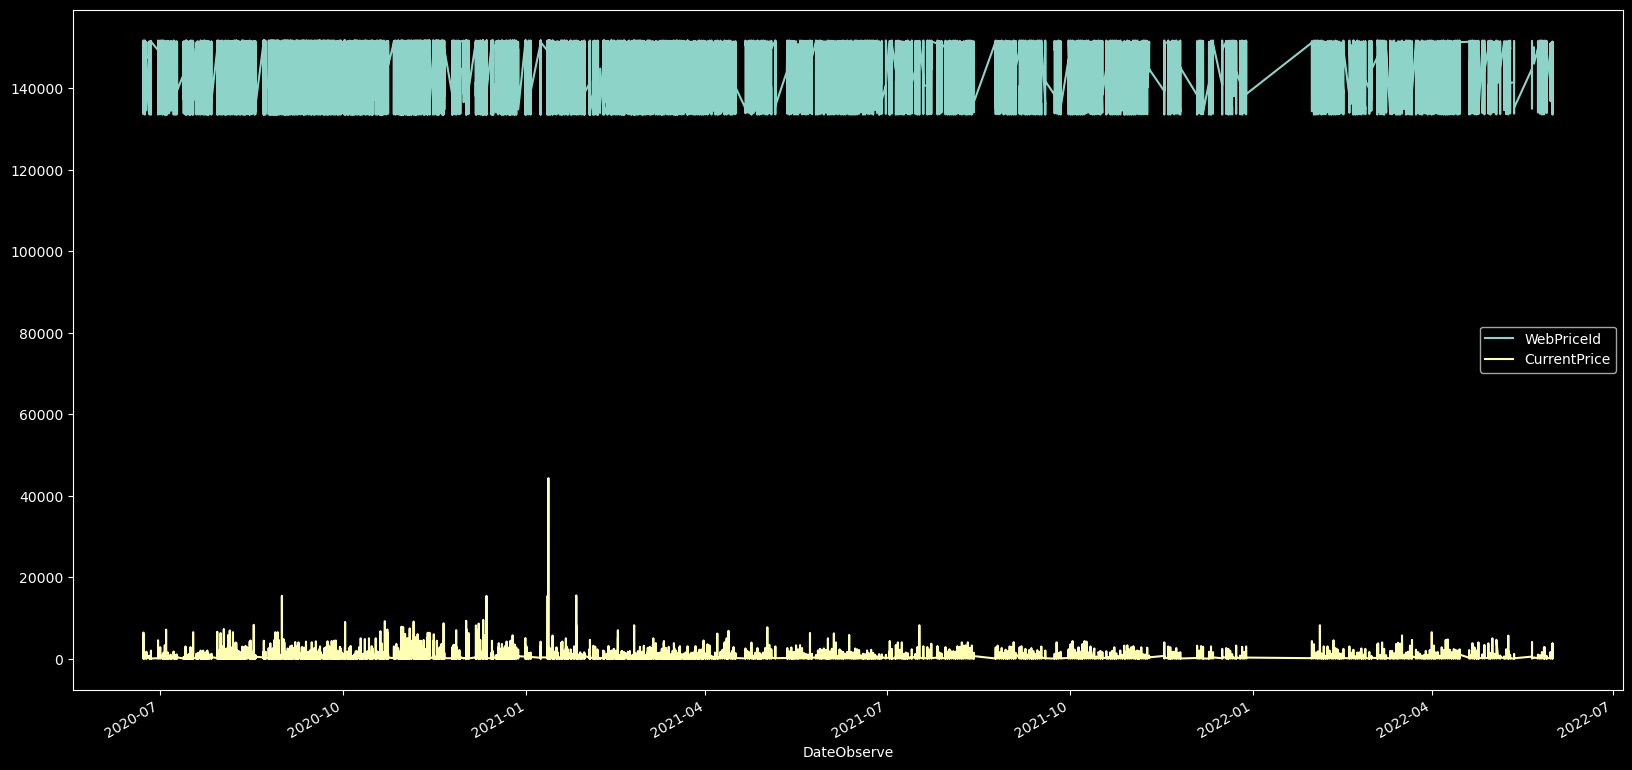

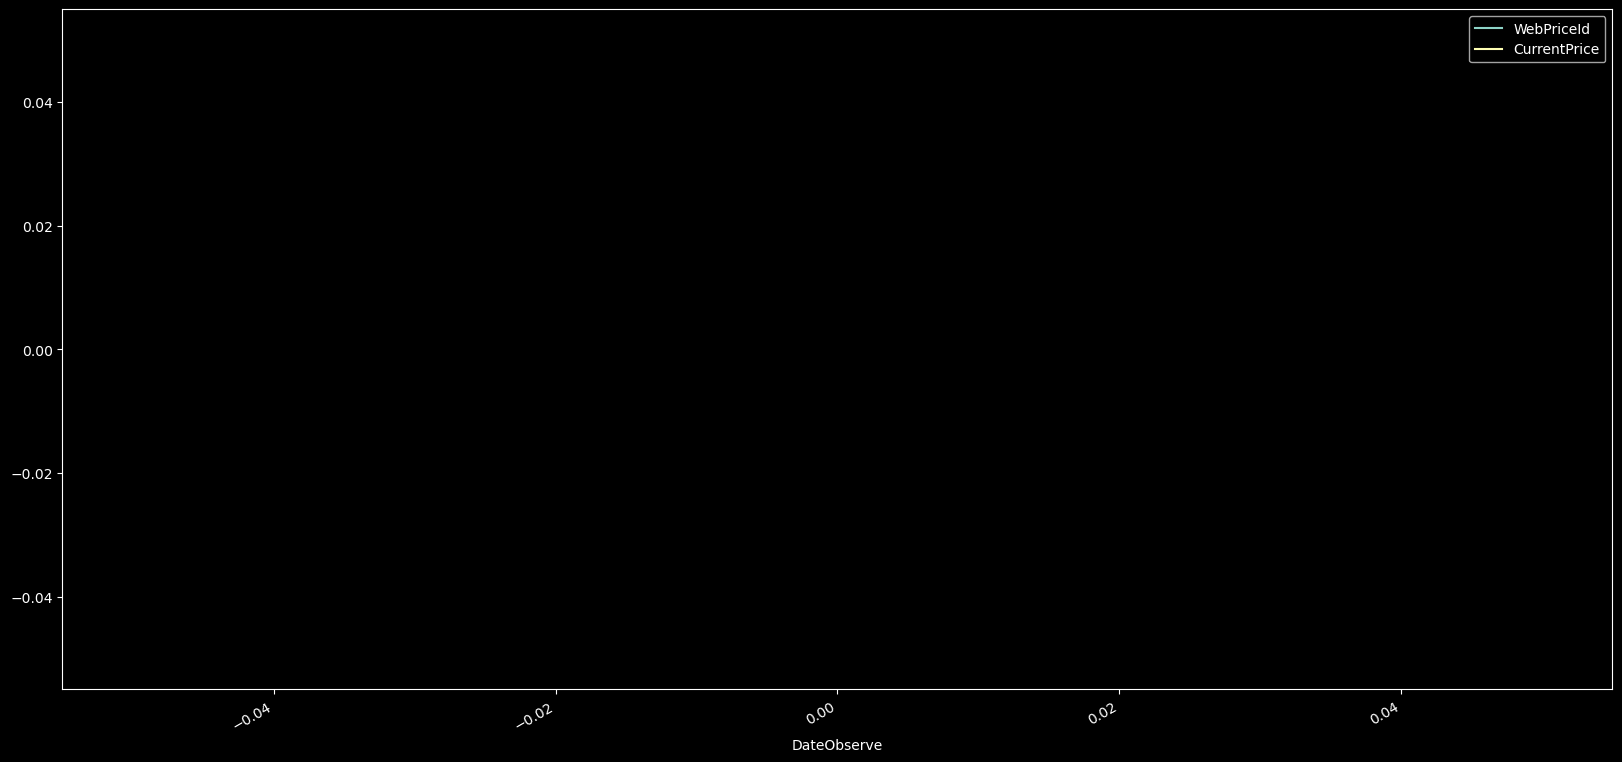

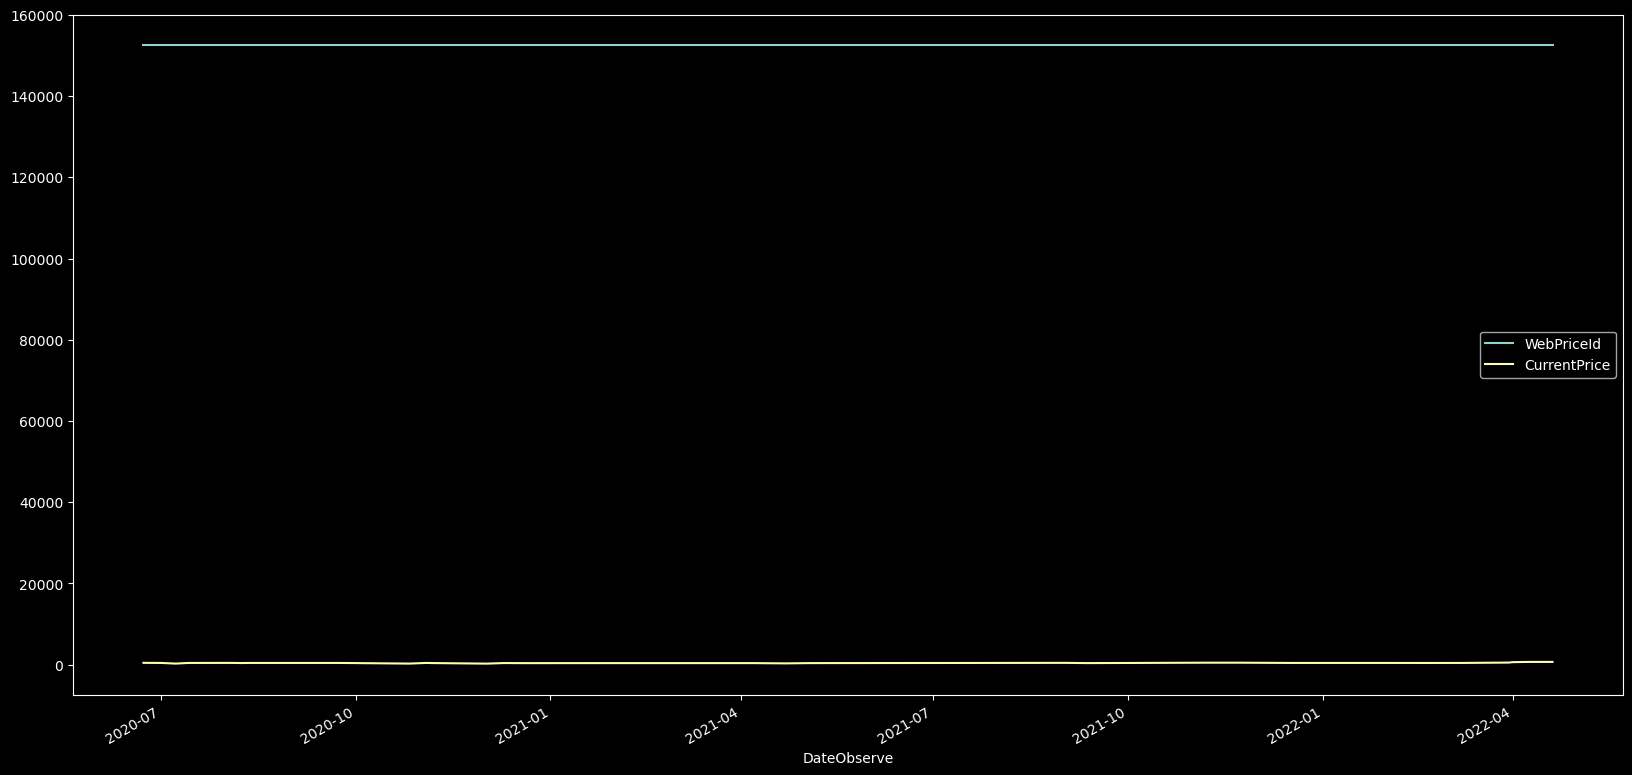

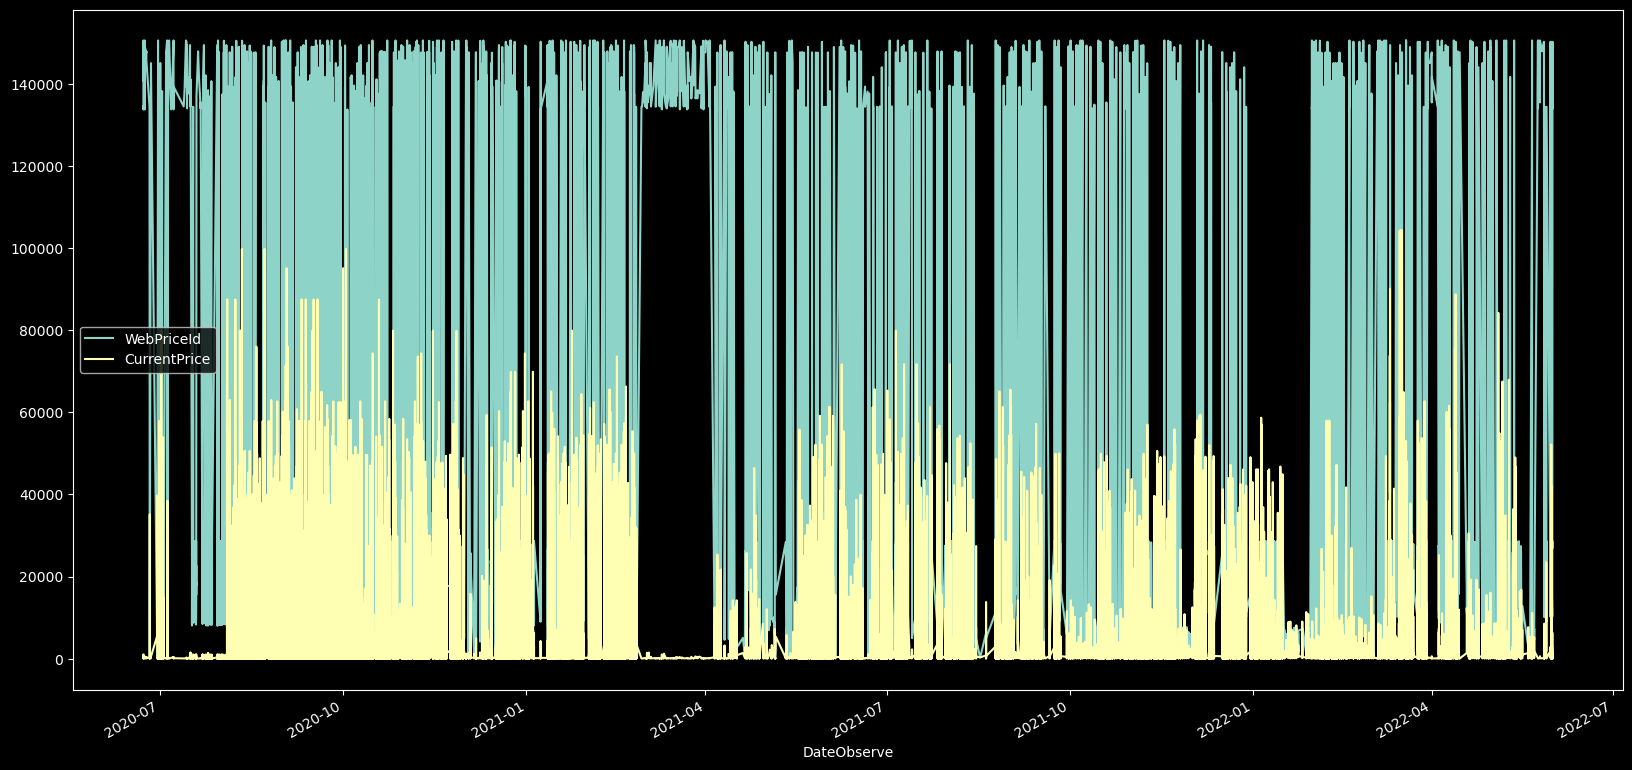

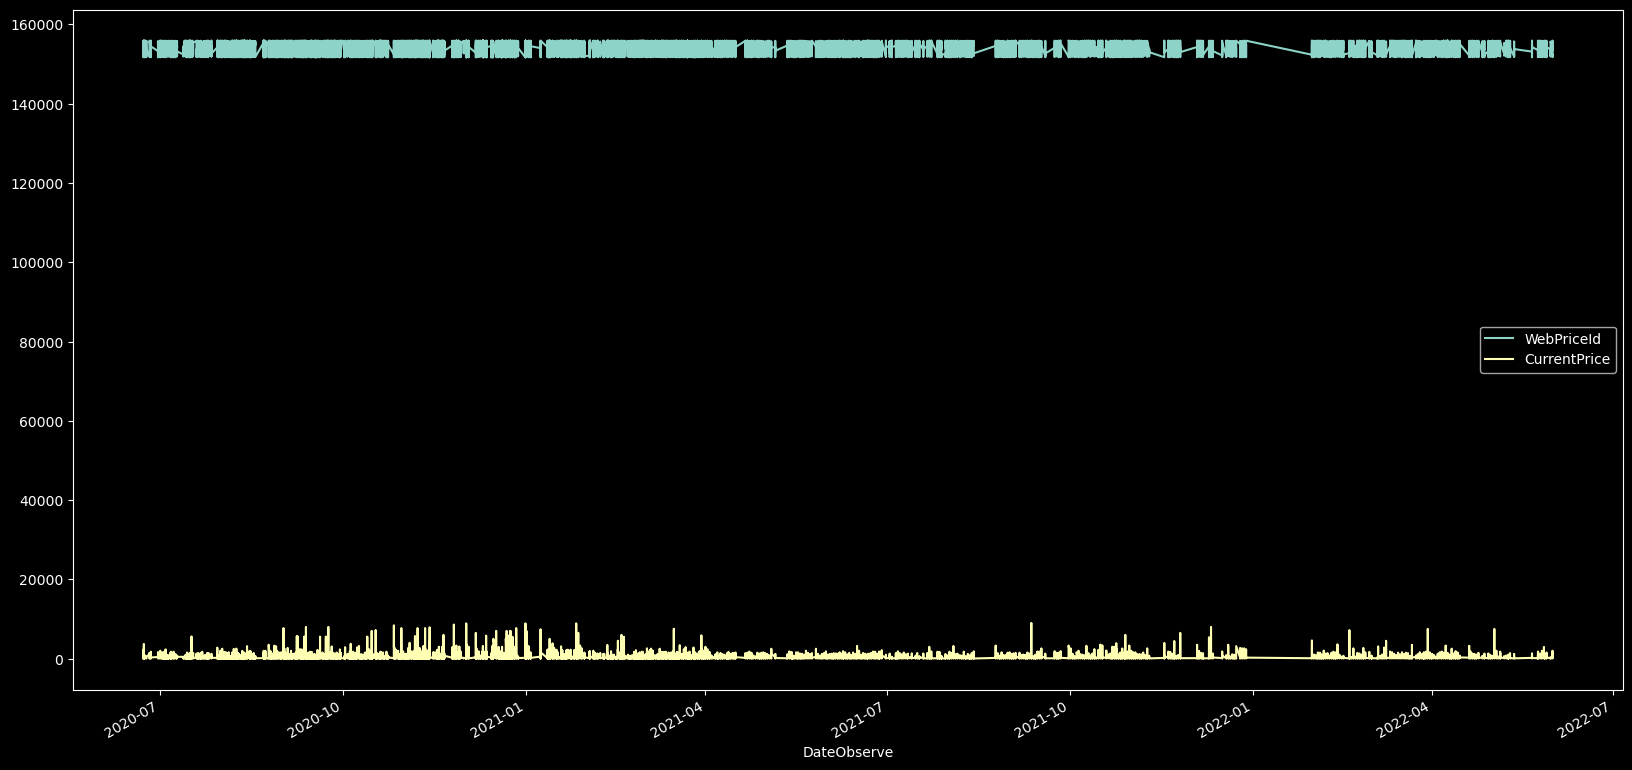

In [260]:
# Get Ids for each cluster
cluster_ids = ids_features.groupby("cluster").groups

cluster_ids

# Get a time series mean plot for each cluster
def get_time_series_mean_plot(df, cluster_id, cluster_ids):
    # Get the ids for the cluster
    ids = cluster_ids[cluster_id]
    # Get the time series for the ids
    time_series = df[df[ID_COLUMN].isin(ids)]
    # Get the mean time series
    mean_time_series = time_series.groupby(DATE_COLUMN).mean()
    # Plot the mean time series
    mean_time_series.plot(figsize=(20, 10))
    plt.show()

# For each cluster, create a time series plot of the mean price across all products in the cluster
for cluster in range(0, n_clusters):
    get_time_series_mean_plot(df_db_sample[:10000000], cluster, cluster_ids)

    